# Breast Cancer Detection - University of Ghana

**Proyecto:** Deteccion de tumores mamarios (benign/malignant) en imagenes de ecografia.

**Modelo:** breast-cancer-detection-phqga/5 (Roboflow Universe)

**Fuente:** https://universe.roboflow.com/university-of-ghana/breast-cancer-detection-phqga

**Autor:** Oscar David Hospinal Jurado - oscardavid.hospinal@uc.cl

---

### Instrucciones

1. Ejecutar todas las celdas secuencialmente de arriba hacia abajo.
2. GPU opcional pero recomendada para procesamiento mas rapido.
3. La interfaz Gradio se lanza en la ultima celda en el puerto 7860.
4. Las imagenes de muestra se descargan automaticamente EN EL DIRECTORIO DEL PROYECTO.
5. La inferencia usa la API serverless de Roboflow (no requiere modelo local).

### Metricas del Modelo

| Metrica | Valor |
|---------|-------|
| mAP@50 | 72.8% |
| Precision | 61.4% |
| Recall | 76.9% |
| Clases | benign, malignant |

## Celda 1: Instalacion de dependencias

In [1]:
!pip install inference-sdk gradio pillow requests matplotlib opencv-python numpy datasets kagglehub --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 12.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.4/217.4 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.9 MB/s eta 0:00:00


## Celda 2: Importaciones

In [2]:
import os
import json
import glob
import shutil
import random
import time
import subprocess
import requests
import numpy as np
import cv2
import matplotlib.pyplot as plt
import gradio as gr
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
from inference_sdk import InferenceHTTPClient, InferenceConfiguration

print("Todas las dependencias importadas correctamente.")

Todas las dependencias importadas correctamente.


## Celda 3: Configuracion de GPU y entorno

In [3]:
import platform


def check_gpu():
    """Detectar y mostrar disponibilidad de GPU e informacion CUDA."""
    print("=" * 60)
    print("CONFIGURACION DEL ENTORNO")
    print("=" * 60)
    print(f"Plataforma: {platform.system()} {platform.release()}")
    print(f"Python: {platform.python_version()}")
    print()

    gpu_available = False
    try:
        import torch
        if torch.cuda.is_available():
            gpu_available = True
            print("CUDA Disponible: Si")
            print(f"Version CUDA: {torch.version.cuda}")
            print(f"Cantidad de GPUs: {torch.cuda.device_count()}")
            for i in range(torch.cuda.device_count()):
                gpu_name = torch.cuda.get_device_name(i)
                props = torch.cuda.get_device_properties(i)
                gpu_mem = getattr(props, "total_memory", getattr(props, "total_mem", 0)) / (1024**3)
                print(f"  GPU {i}: {gpu_name} ({gpu_mem:.1f} GB)")
        else:
            print("CUDA Disponible: No (PyTorch instalado sin soporte CUDA)")
    except ImportError:
        print("PyTorch no instalado. Verificacion CUDA omitida.")

    try:
        result = subprocess.run(
            ["nvidia-smi", "--query-gpu=name,memory.total,driver_version", "--format=csv,noheader"],
            capture_output=True, text=True, timeout=10
        )
        if result.returncode == 0:
            gpu_available = True
            print(f"\nSalida de nvidia-smi:")
            for line in result.stdout.strip().split("\n"):
                print(f"  {line.strip()}")
    except (FileNotFoundError, subprocess.TimeoutExpired):
        if not gpu_available:
            print("\nnvidia-smi: No encontrado.")

    if not gpu_available:
        print("\nNota: No se detecto GPU. La inferencia usara la API serverless de Roboflow,")
        print("que se ejecuta en los servidores de Roboflow. No se requiere GPU local.")
    print("=" * 60)


check_gpu()

CONFIGURACION DEL ENTORNO
Plataforma: Linux 6.6.105+
Python: 3.12.12

CUDA Disponible: Si
Version CUDA: 12.6
Cantidad de GPUs: 1
  GPU 0: Tesla T4 (14.7 GB)

Salida de nvidia-smi:
  Tesla T4, 15360 MiB, 550.54.15


## Celda 4: Funciones auxiliares y configuracion del modelo

**IMPORTANTE:** Se detecta automaticamente el directorio del proyecto para guardar imagenes de forma persistente.

In [4]:
CLASS_COLORS = {
    "benign": (0, 200, 0),
    "malignant": (220, 30, 30),
}
DEFAULT_COLOR = (255, 165, 0)

MODEL_ID = "breast-cancer-detection-phqga/5"
API_KEY = "00BKbj1JjjJshZXYvnKY"
API_URL = "https://serverless.roboflow.com"

# =============================================================================
# DETECCION DEL DIRECTORIO DEL PROYECTO PARA PERSISTENCIA
# =============================================================================
def get_project_dir():
    """Detecta el directorio del proyecto donde se encuentra el notebook.
    
    Busca en ubicaciones conocidas para PyCharm conectado a Colab.
    Prioriza el directorio 'breast-cancer' si existe.
    
    Returns:
        str: Ruta absoluta al directorio del proyecto.
    """
    # Candidatos en orden de prioridad
    candidates = [
        '/content/breast-cancer',           # PyCharm -> Colab con carpeta del proyecto
        '/content/2026-02-Breast-Cancer-Detection/breast-cancer',  # Estructura alternativa
    ]
    
    # Buscar en candidatos
    for path in candidates:
        if os.path.isdir(path):
            # Verificar que existe el notebook o es una carpeta valida del proyecto
            if os.path.exists(os.path.join(path, 'breast_cancer_detection.ipynb')) or \
               os.path.exists(os.path.join(path, 'breast_cancer_detection_v2.ipynb')):
                return path
            # Si la carpeta existe pero no tiene el notebook, igual la usamos
            return path
    
    # Si no encontramos ninguno, usar el directorio actual
    cwd = os.getcwd()
    
    # Si estamos en /content, crear subcarpeta breast-cancer para organizacion
    if cwd == '/content':
        project_path = '/content/breast-cancer'
        os.makedirs(project_path, exist_ok=True)
        return project_path
    
    return cwd


PROJECT_DIR = get_project_dir()
SAMPLE_DIR = os.path.join(PROJECT_DIR, 'sample_images')

print("=" * 60)
print("CONFIGURACION DE DIRECTORIOS")
print("=" * 60)
print(f"Directorio del proyecto: {PROJECT_DIR}")
print(f"Imagenes se guardaran en: {SAMPLE_DIR}")
print(f"Las imagenes PERSISTIRAN en tu proyecto local.")
print("=" * 60)

MODEL_METRICS = {
    "mAP@50": "72.8%",
    "Precision": "61.4%",
    "Recall": "76.9%",
    "Classes": "benign, malignant",
    "Model Version": "5",
    "Source": "University of Ghana",
}


def get_color(class_name):
    """Retorna color RGB para una clase dada."""
    return CLASS_COLORS.get(class_name.lower(), DEFAULT_COLOR)


def resize_if_needed(image, max_dim=1024):
    """Redimensiona la imagen si excede max_dim, manteniendo proporcion."""
    w, h = image.size
    if max(w, h) > max_dim:
        scale = max_dim / max(w, h)
        image = image.resize((int(w * scale), int(h * scale)), Image.LANCZOS)
    return image


def validate_image(image):
    """Valida que el input sea una imagen valida para inferencia."""
    if image is None:
        raise ValueError("No se proporciono imagen.")
    if isinstance(image, np.ndarray):
        if image.ndim not in (2, 3):
            raise ValueError(f"Dimensiones invalidas: {image.ndim}. Se esperan 2 o 3.")
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if image.ndim == 3 else image)
    if not isinstance(image, Image.Image):
        raise ValueError(f"Tipo de imagen no soportado: {type(image)}")
    if image.mode not in ("RGB", "L", "RGBA"):
        image = image.convert("RGB")
    return image


print("\nFunciones auxiliares definidas.")
print(f"Modelo: {MODEL_ID}")
print(f"API URL: {API_URL}")

CONFIGURACION DE DIRECTORIOS
Directorio del proyecto: /content/breast-cancer
Imagenes se guardaran en: /content/breast-cancer/sample_images
Las imagenes PERSISTIRAN en tu proyecto local.

Funciones auxiliares definidas.
Modelo: breast-cancer-detection-phqga/5
API URL: https://serverless.roboflow.com


## Celda 5: Descarga de imagenes de muestra

Las imagenes del proyecto Roboflow estan protegidas (la API key solo permite inferencia).
Se usa el dataset BUSI (Breast Ultrasound Images, Al-Dhabyani et al. 2020) desde Kaggle
como fuente alternativa de imagenes de ecografia mamaria.

**Las imagenes se guardan en la carpeta del proyecto para que persistan.**

DESCARGA DE IMAGENES DE MUESTRA
Destino: /content/breast-cancer/sample_images

Descargando Dataset BUSI desde Kaggle...
Using Colab cache for faster access to the 'breast-ultrasound-images-dataset' dataset.
  Dataset descargado en: /kaggle/input/breast-ultrasound-images-dataset
  Imagenes encontradas: 780
  Copiando 20 imagenes a: /content/breast-cancer/sample_images
    [ 1/20] sample_01_malignant.png (233.0 KB)
    [ 2/20] sample_02_benign.png (432.7 KB)
    [ 3/20] sample_03_benign.png (412.5 KB)
    [ 4/20] sample_04_malignant.png (302.9 KB)
    [ 5/20] sample_05_benign.png (458.8 KB)
    [ 6/20] sample_06_benign.png (277.6 KB)
    [ 7/20] sample_07_benign.png (290.4 KB)
    [ 8/20] sample_08_benign.png (349.0 KB)
    [ 9/20] sample_09_malignant.png (327.7 KB)
    [10/20] sample_10_benign.png (298.7 KB)
    [11/20] sample_11_malignant.png (334.5 KB)
    [12/20] sample_12_malignant.png (345.4 KB)
    [13/20] sample_13_normal.png (439.1 KB)
    [14/20] sample_14_benign.png (256.4 KB)

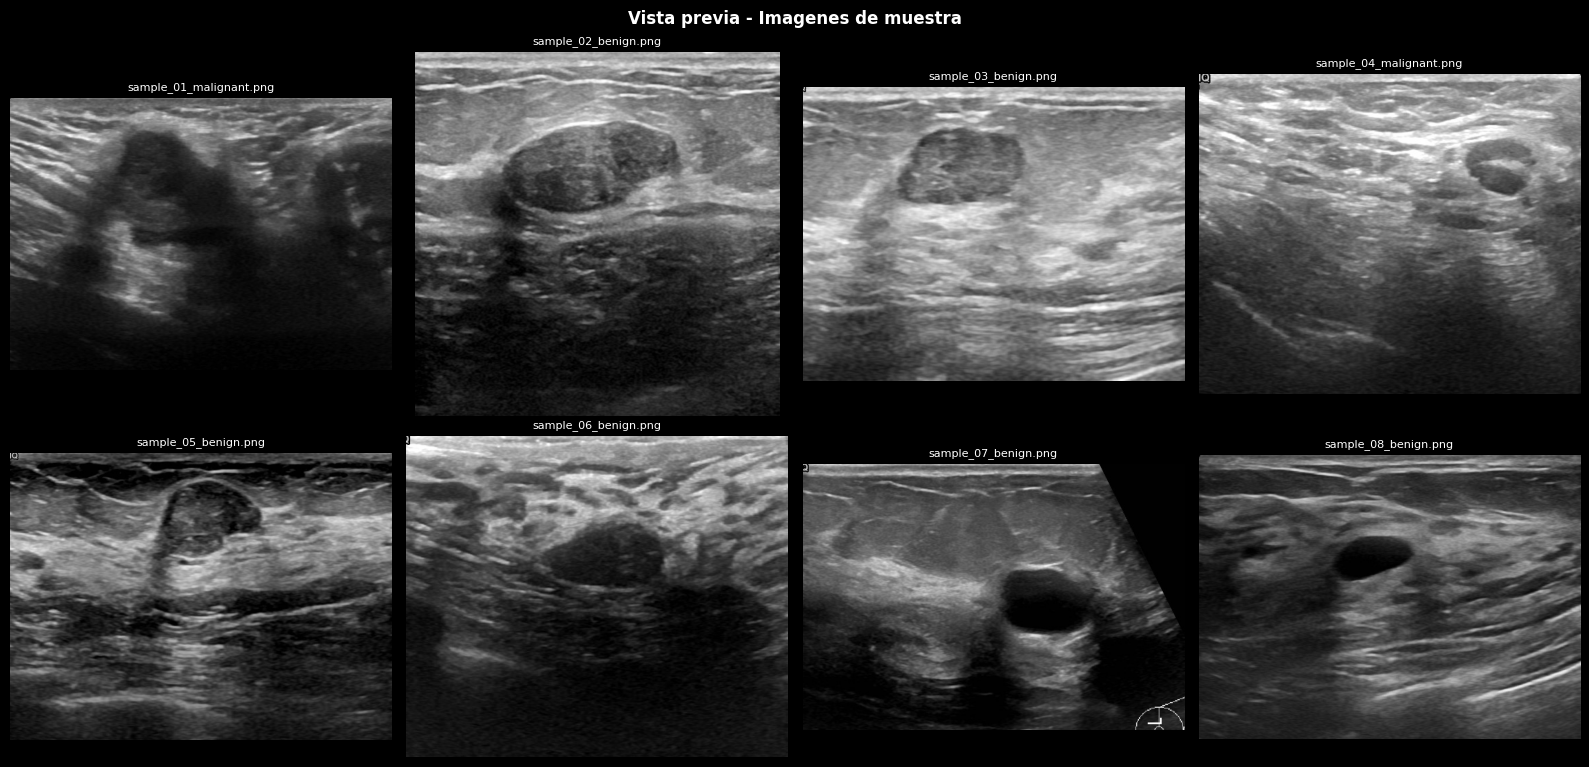

In [5]:
NUM_SAMPLES = 20


def try_kaggle():
    """Descarga BUSI dataset desde Kaggle.

    Usa el cache de Colab si esta disponible.
    Copia las imagenes al directorio del proyecto.

    Returns:
        list: Rutas de imagenes descargadas, o lista vacia.
    """
    print("Descargando Dataset BUSI desde Kaggle...")
    
    # Configurar credenciales si estan en Colab Secrets
    try:
        from google.colab import userdata
        os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
        os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")
        print("  Credenciales cargadas desde Colab Secrets.")
    except Exception:
        pass

    kaggle_id = "aryashah2k/breast-ultrasound-images-dataset"

    try:
        import kagglehub
        path = kagglehub.dataset_download(kaggle_id)
        print(f"  Dataset descargado en: {path}")
    except Exception as e:
        print(f"  Error kagglehub: {e}")
        return []

    # Buscar imagenes en el dataset descargado
    all_images = []
    for ext in ("*.jpg", "*.jpeg", "*.png"):
        all_images.extend(glob.glob(os.path.join(path, "**", ext), recursive=True))
    
    # Filtrar masks (mascaras de segmentacion)
    all_images = [
        p for p in all_images
        if "_mask" not in os.path.basename(p).lower()
        and "mask" not in os.path.basename(os.path.dirname(p)).lower()
    ]
    
    if not all_images:
        print("  No se encontraron imagenes en el dataset.")
        return []

    print(f"  Imagenes encontradas: {len(all_images)}")
    random.seed(42)
    selected = random.sample(all_images, min(NUM_SAMPLES, len(all_images)))

    # CREAR CARPETA EN EL DIRECTORIO DEL PROYECTO
    os.makedirs(SAMPLE_DIR, exist_ok=True)
    print(f"  Copiando {len(selected)} imagenes a: {SAMPLE_DIR}")
    
    paths = []
    for i, src in enumerate(selected, 1):
        # Determinar clase basada en el nombre del directorio padre
        parent = os.path.basename(os.path.dirname(src)).lower()
        if "benign" in parent:
            clase = "benign"
        elif "malignant" in parent:
            clase = "malignant"
        elif "normal" in parent:
            clase = "normal"
        else:
            clase = "unknown"
        
        ext = os.path.splitext(src)[1]
        dest = os.path.join(SAMPLE_DIR, f"sample_{i:02d}_{clase}{ext}")
        shutil.copy2(src, dest)
        paths.append(dest)
        size_kb = os.path.getsize(dest) / 1024
        print(f"    [{i:2d}/{len(selected)}] sample_{i:02d}_{clase}{ext} ({size_kb:.1f} KB)")
    
    return paths


# =====================================================
# EJECUCION
# =====================================================
print("=" * 60)
print("DESCARGA DE IMAGENES DE MUESTRA")
print("=" * 60)
print(f"Destino: {SAMPLE_DIR}")
print()

os.makedirs(SAMPLE_DIR, exist_ok=True)
existing = sorted(
    glob.glob(os.path.join(SAMPLE_DIR, "*.jpg")) +
    glob.glob(os.path.join(SAMPLE_DIR, "*.png"))
)

if len(existing) >= 5:
    print(f"Imagenes ya disponibles ({len(existing)} en {SAMPLE_DIR})")
    sample_paths = existing
else:
    sample_paths = try_kaggle()

    if not sample_paths:
        print("\n" + "=" * 60)
        print("CONFIGURACION NECESARIA")
        print("=" * 60)
        print("")
        print("Opcion A - Configurar Kaggle (recomendado):")
        print("  1. Ve a https://www.kaggle.com/settings")
        print("  2. Seccion 'API' > Click 'Create New Token'")
        print("  3. Configura KAGGLE_USERNAME y KAGGLE_KEY en Colab Secrets")
        print("  4. Vuelve a ejecutar esta celda.")
        print("")
        print("Opcion B - Subir imagenes manualmente:")
        print("  1. Descarga de: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset")
        print(f"  2. Sube ~20 imagenes .png a la carpeta: {SAMPLE_DIR}")
        print("  3. Vuelve a ejecutar esta celda.")
        print("=" * 60)

# Re-leer desde el directorio por si se copiaron
sample_paths = sorted(
    glob.glob(os.path.join(SAMPLE_DIR, "*.jpg")) +
    glob.glob(os.path.join(SAMPLE_DIR, "*.png"))
)

# Indice
print("\n" + "=" * 60)
print("INDICE DE IMAGENES DE MUESTRA")
print("=" * 60)
for i, path in enumerate(sample_paths, 1):
    size_kb = os.path.getsize(path) / 1024
    name = os.path.basename(path)
    print(f"  {i:2d}. {name:40s} {size_kb:8.1f} KB")
print(f"\nTotal: {len(sample_paths)} imagenes en {SAMPLE_DIR}")
print(f"\n*** IMPORTANTE: Las imagenes se guardaron en el directorio del proyecto ***")
print(f"*** Carpeta: {SAMPLE_DIR} ***")

# Vista previa
if sample_paths:
    preview_count = min(8, len(sample_paths))
    cols = 4
    rows = max(1, (preview_count + cols - 1) // cols)
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1:
        axes = list(axes)
    else:
        axes = axes.flatten().tolist()
    for idx in range(rows * cols):
        if idx < preview_count:
            img = Image.open(sample_paths[idx])
            axes[idx].imshow(img, cmap="gray" if img.mode == "L" else None)
            axes[idx].set_title(os.path.basename(sample_paths[idx]), fontsize=8)
        axes[idx].axis("off")
    plt.suptitle("Vista previa - Imagenes de muestra", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()

## Celda 6: Inicializacion del cliente Roboflow

In [6]:
def initialize_client():
    """Inicializa el cliente InferenceHTTPClient con la API serverless de Roboflow."""
    try:
        client = InferenceHTTPClient(
            api_url=API_URL,
            api_key=API_KEY,
        )
        print("Cliente de inferencia Roboflow inicializado.")
        print(f"  API URL:  {API_URL}")
        print(f"  Modelo:   {MODEL_ID}")
        print(f"  API Key:  {API_KEY[:8]}...")
        return client
    except Exception as e:
        raise ConnectionError(f"Error inicializando cliente Roboflow: {e}")


CLIENT = initialize_client()

if sample_paths:
    try:
        test_result = CLIENT.infer(sample_paths[0], model_id=MODEL_ID)
        pred_count = len(test_result.get("predictions", []))
        print(f"\nTest de conectividad: OK ({pred_count} predicciones en imagen de prueba)")
    except Exception as e:
        print(f"\nTest de conectividad fallido: {e}")
        print("La interfaz se lanzara igualmente. Verifica tu API key y conexion.")

Cliente de inferencia Roboflow inicializado.
  API URL:  https://serverless.roboflow.com
  Modelo:   breast-cancer-detection-phqga/5
  API Key:  00BKbj1J...

Test de conectividad: OK (0 predicciones en imagen de prueba)


In [8]:
# === DESCARGAR IMAGENES A TU PC ===
import shutil
import os

# Buscar donde están las imágenes
paths_to_check = [
    '/content/breast-cancer/sample_images',
    '/content/sample_images',
    '/content/drive/MyDrive/BreastCancerDetection/sample_images',
]

sample_dir = None
for p in paths_to_check:
    if os.path.exists(p) and os.listdir(p):
        sample_dir = p
        break

if sample_dir:
    files_count = len([f for f in os.listdir(sample_dir) if f.endswith(('.png', '.jpg'))])
    print(f"✓ Encontradas {files_count} imagenes en: {sample_dir}")

    # Crear ZIP
    zip_path = '/content/sample_images_download'
    shutil.make_archive(zip_path, 'zip', sample_dir)
    print(f"✓ ZIP creado: {zip_path}.zip")

    # Descargar
    from google.colab import files
    files.download(f'{zip_path}.zip')
    print("✓ Descarga iniciada - revisa tu carpeta de Descargas")
else:
    print("✗ No se encontraron imagenes. Ejecuta primero la celda de descarga (Celda 5).")

✓ Encontradas 20 imagenes en: /content/breast-cancer/sample_images
✓ ZIP creado: /content/sample_images_download.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Descarga iniciada - revisa tu carpeta de Descargas


In [9]:
# Copiar directamente a tu proyecto local
!cp -r /content/breast-cancer/sample_images /content/breast-cancer/
print("Listo! Refresca el explorador de archivos en PyCharm")

cp: '/content/breast-cancer/sample_images' and '/content/breast-cancer/sample_images' are the same file
Listo! Refresca el explorador de archivos en PyCharm


In [15]:
# === METODO GOOGLE DRIVE ===
from google.colab import drive
import shutil
import os

# 1. Montar Google Drive
print("Montando Google Drive...")
drive.mount('/content/drive')

# 2. Crear carpeta en Drive y copiar imágenes
drive_folder = '/content/drive/MyDrive/BreastCancerImages'
source_folder = '/content/breast-cancer/sample_images'

os.makedirs(drive_folder, exist_ok=True)

print(f"Copiando imágenes a Google Drive...")
for f in os.listdir(source_folder):
    if f.endswith(('.png', '.jpg', '.jpeg')):
        shutil.copy2(os.path.join(source_folder, f), drive_folder)
        print(f"  ✓ {f}")

print(f"\n{'='*50}")
print("LISTO! Las imágenes están en tu Google Drive:")
print("  📁 Mi unidad > BreastCancerImages")
print("")
print("Ahora en tu PC:")
print("  1. Abre Google Drive en el navegador o app de escritorio")
print("  2. Descarga la carpeta 'BreastCancerImages'")
print("  3. Cópiala a tu proyecto local")
print("="*50)

Montando Google Drive...


ValueError: mount failed

## Celda 7: Funciones de inferencia y visualizacion

In [11]:
def run_inference(image, confidence_threshold=40):
    """Ejecuta inferencia de deteccion de objetos sobre la imagen dada."""
    config = InferenceConfiguration(confidence_threshold=confidence_threshold / 100.0)
    CLIENT.configure(config)

    if isinstance(image, str):
        if not os.path.exists(image) and not image.startswith("http"):
            raise FileNotFoundError(f"Imagen no encontrada: {image}")
        result = CLIENT.infer(image, model_id=MODEL_ID)
    elif isinstance(image, np.ndarray):
        pil_img = Image.fromarray(image)
        pil_img = resize_if_needed(pil_img)
        temp_path = os.path.join(SAMPLE_DIR, "_temp_inference.jpg")
        pil_img.save(temp_path, quality=95)
        result = CLIENT.infer(temp_path, model_id=MODEL_ID)
        os.remove(temp_path)
    elif isinstance(image, Image.Image):
        image = resize_if_needed(image)
        temp_path = os.path.join(SAMPLE_DIR, "_temp_inference.jpg")
        image.save(temp_path, quality=95)
        result = CLIENT.infer(temp_path, model_id=MODEL_ID)
        os.remove(temp_path)
    else:
        raise ValueError(f"Tipo de imagen no soportado: {type(image)}")
    return result


def draw_detections(image, predictions):
    """Dibuja bounding boxes, etiquetas y confianza sobre la imagen."""
    if isinstance(image, np.ndarray):
        img = image.copy()
    elif isinstance(image, Image.Image):
        img = np.array(image)
    else:
        raise ValueError(f"Tipo no soportado: {type(image)}")

    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

    img_h, img_w = img.shape[:2]
    thickness = max(2, int(min(img_h, img_w) / 200))
    font_scale = max(0.5, min(img_h, img_w) / 800)

    for pred in predictions:
        class_name = pred.get("class", "unknown")
        confidence = pred.get("confidence", 0)
        x_center = pred.get("x", 0)
        y_center = pred.get("y", 0)
        width = pred.get("width", 0)
        height = pred.get("height", 0)

        x1 = max(0, int(x_center - width / 2))
        y1 = max(0, int(y_center - height / 2))
        x2 = min(img_w, int(x_center + width / 2))
        y2 = min(img_h, int(y_center + height / 2))

        color = get_color(class_name)
        label = f"{class_name} {confidence * 100:.1f}%"

        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)

        (label_w, label_h), baseline = cv2.getTextSize(
            label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness
        )
        label_y1 = max(0, y1 - label_h - baseline - 6)
        cv2.rectangle(img, (x1, label_y1), (x1 + label_w + 4, y1), color, -1)
        cv2.putText(
            img, label, (x1 + 2, y1 - baseline - 2),
            cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness
        )
    return img


def build_results_table(predictions):
    """Construye tabla HTML con el resumen de detecciones."""
    if not predictions:
        return "<p style='text-align:center; color:#888;'>Sin detecciones al umbral de confianza seleccionado.</p>"

    rows = ""
    for i, pred in enumerate(predictions, 1):
        cls = pred.get("class", "unknown")
        conf = pred.get("confidence", 0) * 100
        x = pred.get("x", 0)
        y = pred.get("y", 0)
        w = pred.get("width", 0)
        h = pred.get("height", 0)
        color = "#22c55e" if cls.lower() == "benign" else "#ef4444"
        rows += f"""
        <tr>
            <td style='text-align:center'>{i}</td>
            <td style='text-align:center'><span style='color:{color}; font-weight:bold'>{cls.upper()}</span></td>
            <td style='text-align:center'>{conf:.1f}%</td>
            <td style='text-align:center'>{x:.0f}</td>
            <td style='text-align:center'>{y:.0f}</td>
            <td style='text-align:center'>{w:.0f}</td>
            <td style='text-align:center'>{h:.0f}</td>
        </tr>"""

    table = f"""
    <table style='width:100%; border-collapse:collapse; font-family:monospace; font-size:14px;'>
        <thead>
            <tr style='background:#1e293b; color:white;'>
                <th style='padding:8px'>#</th>
                <th style='padding:8px'>Clase</th>
                <th style='padding:8px'>Confianza</th>
                <th style='padding:8px'>X</th>
                <th style='padding:8px'>Y</th>
                <th style='padding:8px'>Ancho</th>
                <th style='padding:8px'>Alto</th>
            </tr>
        </thead>
        <tbody>{rows}</tbody>
    </table>"""

    total = len(predictions)
    avg_conf = sum(p.get("confidence", 0) for p in predictions) / total * 100
    classes = [p.get("class", "unknown") for p in predictions]
    benign_count = sum(1 for c in classes if c.lower() == "benign")
    malignant_count = sum(1 for c in classes if c.lower() == "malignant")

    if benign_count > malignant_count:
        predominant, pred_color = "BENIGNO", "#22c55e"
    elif malignant_count > benign_count:
        predominant, pred_color = "MALIGNO", "#ef4444"
    else:
        predominant, pred_color = "IGUAL", "#f59e0b"

    stats = f"""
    <div style='margin-top:16px; padding:12px; background:#f1f5f9; border-radius:8px;'>
        <h4 style='margin:0 0 8px 0;'>Estadisticas de Deteccion</h4>
        <p style='margin:4px 0;'>Total tumores detectados: <strong>{total}</strong></p>
        <p style='margin:4px 0;'>Benignos: <strong style='color:#22c55e'>{benign_count}</strong>
           | Malignos: <strong style='color:#ef4444'>{malignant_count}</strong></p>
        <p style='margin:4px 0;'>Confianza promedio: <strong>{avg_conf:.1f}%</strong></p>
        <p style='margin:4px 0;'>Clase predominante:
            <strong style='color:{pred_color}'>{predominant}</strong></p>
    </div>"""
    return table + stats


print("Funciones de inferencia y visualizacion definidas.")

Funciones de inferencia y visualizacion definidas.


## Celda 8: Interfaz Gradio

In [12]:
def get_sample_choices():
    """Retorna lista de rutas de imagenes de muestra para el dropdown de Gradio."""
    if not os.path.exists(SAMPLE_DIR):
        return []
    return sorted([
        os.path.join(SAMPLE_DIR, f)
        for f in os.listdir(SAMPLE_DIR)
        if f.lower().endswith((".png", ".jpg", ".jpeg")) and not f.startswith("_")
    ])


def process_inference(uploaded_image, sample_choice, confidence):
    """Funcion principal de procesamiento para la interfaz Gradio."""
    image = None
    source = ""

    if uploaded_image is not None:
        image = uploaded_image
        source = "imagen subida"
    elif sample_choice:
        if os.path.exists(sample_choice):
            image = np.array(Image.open(sample_choice).convert("RGB"))
            source = os.path.basename(sample_choice)
        else:
            return None, "<p style='color:red;'>Imagen de muestra no encontrada.</p>"
    else:
        return None, "<p style='color:red;'>Suba una imagen o seleccione una muestra.</p>"

    try:
        image = validate_image(image)
    except ValueError as e:
        return None, f"<p style='color:red;'>Error de validacion: {e}</p>"

    try:
        result = run_inference(image, confidence_threshold=confidence)
    except Exception as e:
        return None, f"<p style='color:red;'>Error de inferencia: {e}</p>"

    predictions = result.get("predictions", [])
    img_array = np.array(image) if isinstance(image, Image.Image) else image
    annotated = draw_detections(img_array, predictions)
    results_html = build_results_table(predictions)
    results_html += f"<p style='color:#64748b; font-size:12px; margin-top:8px;'>Fuente: {source}</p>"
    return annotated, results_html


def build_model_info():
    """Construye el panel HTML de informacion del modelo."""
    samples = get_sample_choices()
    sample_list = "".join(f"<li>{os.path.basename(s)}</li>" for s in samples)
    return f"""
    <div style='font-family:sans-serif; font-size:14px;'>
        <h3>Informacion del Modelo</h3>
        <table style='width:100%; border-collapse:collapse;'>
            <tr><td style='padding:4px; font-weight:bold;'>Modelo</td><td style='padding:4px;'>{MODEL_ID}</td></tr>
            <tr><td style='padding:4px; font-weight:bold;'>mAP@50</td><td style='padding:4px;'>{MODEL_METRICS['mAP@50']}</td></tr>
            <tr><td style='padding:4px; font-weight:bold;'>Precision</td><td style='padding:4px;'>{MODEL_METRICS['Precision']}</td></tr>
            <tr><td style='padding:4px; font-weight:bold;'>Recall</td><td style='padding:4px;'>{MODEL_METRICS['Recall']}</td></tr>
            <tr><td style='padding:4px; font-weight:bold;'>Clases</td><td style='padding:4px;'>{MODEL_METRICS['Classes']}</td></tr>
            <tr><td style='padding:4px; font-weight:bold;'>Fuente</td><td style='padding:4px;'>{MODEL_METRICS['Source']}</td></tr>
        </table>
        <h4 style='margin-top:16px;'>Leyenda de Clases</h4>
        <p><span style='color:#22c55e; font-weight:bold;'>VERDE</span> = Benigno</p>
        <p><span style='color:#ef4444; font-weight:bold;'>ROJO</span> = Maligno</p>
        <h4 style='margin-top:16px;'>Imagenes de Muestra Disponibles ({len(samples)})</h4>
        <ul style='margin:0; padding-left:20px;'>{sample_list}</ul>
        <p style='margin-top:12px; color:#64748b;'>Carpeta: {SAMPLE_DIR}</p>
    </div>"""


sample_choices = get_sample_choices()

with gr.Blocks(
    title="Breast Cancer Detection - University of Ghana",
    theme=gr.themes.Soft(),
) as demo:

    gr.Markdown(
        "# Deteccion de Cancer de Mama\n"
        "**University of Ghana** | Modelo: breast-cancer-detection-phqga/5\n\n"
        "Suba una imagen de ecografia mamaria o seleccione una muestra para detectar tumores benignos y malignos."
    )

    with gr.Row():
        with gr.Column(scale=1):
            gr.Markdown("### Entrada")
            input_image = gr.Image(label="Subir Imagen (JPG, PNG)", type="numpy", sources=["upload", "clipboard"])
            sample_dropdown = gr.Dropdown(choices=sample_choices, label="O seleccionar imagen de muestra", value=None, interactive=True)
            confidence_slider = gr.Slider(minimum=0, maximum=100, value=40, step=1, label="Confianza Minima (%)")
            run_btn = gr.Button("Ejecutar Inferencia", variant="primary", size="lg")

        with gr.Column(scale=2):
            gr.Markdown("### Resultados")
            output_image = gr.Image(label="Resultados de Deteccion", type="numpy", interactive=False)
            results_html = gr.HTML(label="Detalles", value="<p style='text-align:center; color:#888;'>Ejecute la inferencia para ver resultados.</p>")

    with gr.Accordion("Informacion del Modelo y Metricas", open=False):
        gr.HTML(build_model_info())

    run_btn.click(
        fn=process_inference,
        inputs=[input_image, sample_dropdown, confidence_slider],
        outputs=[output_image, results_html],
    )

print("Interfaz Gradio construida. Lista para lanzar.")

Interfaz Gradio construida. Lista para lanzar.


## Celda 9: Lanzar servidor Gradio

In [13]:
try:
    import google.colab
    is_colab = True
except ImportError:
    is_colab = False

demo.launch(
    server_port=7860,
    share=is_colab,
    show_error=True,
    quiet=False,
)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5c605e052c6165d1ee.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
